# Chapter 16: Checking the Model and Data

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

This notebook provides an interactive introduction to regression diagnostics and model validation. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch16_Checking_the_Model_and_Data.ipynb)

## Chapter Overview

This chapter focuses on checking model assumptions and diagnosing data problems. You'll gain both theoretical understanding and practical skills through hands-on Python examples.

**What you'll learn:**
- Detecting and diagnosing multicollinearity (VIF, correlation matrices)
- Understanding failures of model assumptions and their consequences
- Testing for heteroskedasticity (graphical and formal tests)
- Detecting autocorrelation in time series models
- Using heteroskedasticity-robust and HAC standard errors
- Creating diagnostic plots (residual, component+residual, added variable)
- Identifying influential observations (DFITS, DFBETAS)
- Applying diagnostics to real-world data (democracy and growth)

**Datasets used:**
- **AED_EARNINGS_COMPLETE.DTA**: 842 full-time workers (2010)
- **AED_DEMOCRACY.DTA**: 131 countries (Acemoglu et al. 2008)

**Key economic questions:**
- Does democracy promote economic growth?
- What role do institutions (religion, constraints) play?
- Are there influential countries driving the results?
- Is the relationship linear or nonlinear?

**Sections covered:**
1. Multicollinearity
2. Model Assumptions Revisited
3. Incorrect Population Model
4. Regressors Correlated with Errors
5. Heteroskedastic Errors
6. Correlated Errors (Autocorrelation)
7. Example: Democracy and Growth
8. Diagnostics (Residual Plots, Influential Observations)

**Estimated time:** 90-120 minutes

## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [6]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_white, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import acf
from scipy import stats
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("="*70)
print("CHAPTER 16: CHECKING THE MODEL AND DATA")
print("="*70)
print("\nSetup complete! Ready to explore model diagnostics.")

CHAPTER 16: CHECKING THE MODEL AND DATA

Setup complete! Ready to explore model diagnostics.


## 16.1: Multicollinearity

Multicollinearity occurs when regressors are highly correlated with each other. While OLS remains unbiased and consistent, individual coefficients may be imprecisely estimated.

**Effects of multicollinearity:**
- High standard errors on individual coefficients
- Low t-statistics (coefficients appear insignificant)
- Coefficients may have "wrong" signs
- Coefficients very sensitive to small data changes
- Joint tests may still be significant

**Detection methods:**
1. **High pairwise correlations** between regressors
2. **Variance Inflation Factor (VIF)**:
   $$VIF_j = \frac{1}{1 - R_j^2}$$
   where $R_j^2$ is from regressing $x_j$ on all other regressors
   - VIF > 10 indicates serious multicollinearity
   - VIF > 5 suggests investigating further

3. **Auxiliary regression**: Regress one variable on others
   - High $R^2$ indicates multicollinearity

**Example**: Earnings regression with age, education, and age×education interaction

In [7]:
# Read earnings data
data_earnings = pd.read_stata(GITHUB_DATA_URL + 'AED_EARNINGS_COMPLETE.DTA')

print("="*70)
print("16.1 MULTICOLLINEARITY")
print("="*70)

print("\nData summary:")
print(data_earnings[['earnings', 'age', 'education', 'agebyeduc']].describe())

# Base model without interaction
print("\n" + "-"*70)
print("Base Model: earnings ~ age + education")
print("-"*70)
model_base = ols('earnings ~ age + education', data=data_earnings).fit(cov_type='HC1')
print(model_base.summary())

16.1 MULTICOLLINEARITY

Data summary:
            earnings         age   education    agebyeduc
count     872.000000  872.000000  872.000000   872.000000
mean    56368.691406   43.310780   13.853211   598.819946
std     51516.054688   10.676045    2.884141   193.690643
min      4000.000000   25.000000    0.000000     0.000000
25%     29000.000000   35.000000   12.000000   464.000000
50%     44200.000000   44.000000   13.000000   588.000000
75%     64250.000000   51.250000   16.000000   720.000000
max    504000.000000   65.000000   20.000000  1260.000000

----------------------------------------------------------------------
Base Model: earnings ~ age + education
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:              

In [8]:
# Model with interaction (creates multicollinearity)
print("\n" + "-"*70)
print("Collinear Model: earnings ~ age + education + agebyeduc")
print("-"*70)
model_collinear = ols('earnings ~ age + education + agebyeduc', 
                      data=data_earnings).fit(cov_type='HC1')
print(model_collinear.summary())

print("\nNote: Compare standard errors between base and collinear models.")
print("Standard errors increase dramatically with the interaction term.")


----------------------------------------------------------------------
Collinear Model: earnings ~ age + education + agebyeduc
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     31.80
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           1.65e-19
Time:                        14:15:10   Log-Likelihood:                -10644.
No. Observations:                 872   AIC:                         2.130e+04
Df Residuals:                     868   BIC:                         2.132e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
           


----------------------------------------------------------------------
Correlation Matrix of Regressors
----------------------------------------------------------------------
                age  education  agebyeduc
age        1.000000  -0.038153   0.729136
education -0.038153   1.000000   0.635961
agebyeduc  0.729136   0.635961   1.000000


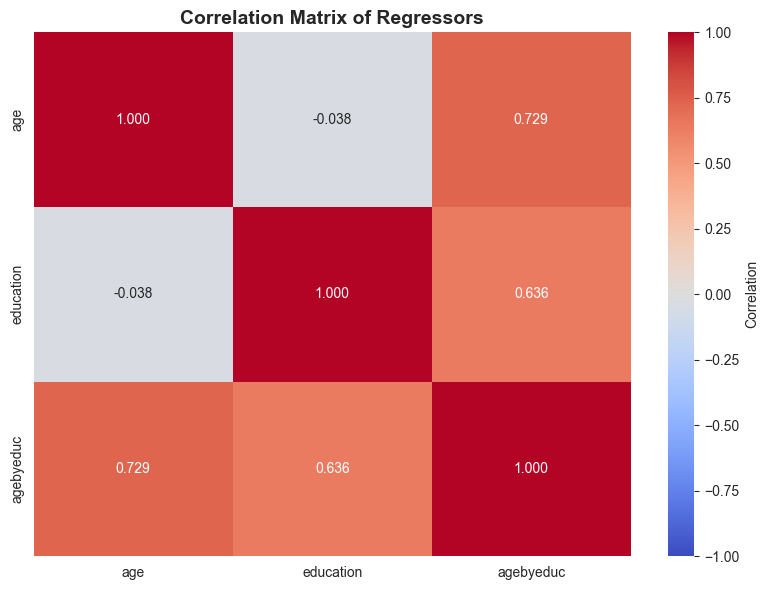


High correlations (> 0.9) indicate multicollinearity.


In [9]:
# Correlation matrix
print("\n" + "-"*70)
print("Correlation Matrix of Regressors")
print("-"*70)
corr_matrix = data_earnings[['age', 'education', 'agebyeduc']].corr()
print(corr_matrix)

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix of Regressors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHigh correlations (> 0.9) indicate multicollinearity.")

In [10]:
# Calculate VIF for all regressors
print("\n" + "-"*70)
print("Variance Inflation Factors (VIF)")
print("-"*70)

# Prepare data for VIF calculation
X_vif = data_earnings[['age', 'education', 'agebyeduc']].copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print(vif_data)

print("\nInterpretation:")
print("  VIF > 10 indicates serious multicollinearity")
print("  VIF > 5 suggests investigating further")
print(f"  agebyeduc VIF = {vif_data.loc[vif_data['Variable']=='agebyeduc', 'VIF'].values[0]:.1f} (SEVERE!)")


----------------------------------------------------------------------
Variance Inflation Factors (VIF)
----------------------------------------------------------------------
    Variable         VIF
0      const  411.323019
1        age   21.996182
2  education   17.298404
3  agebyeduc   36.880231

Interpretation:
  VIF > 10 indicates serious multicollinearity
  VIF > 5 suggests investigating further
  agebyeduc VIF = 36.9 (SEVERE!)


---

### 🚨 Understanding VIF: When Multicollinearity Becomes a Problem

The VIF (Variance Inflation Factor) results reveal **severe multicollinearity** in the interaction model. Let's understand what this means:

**VIF Values from the Analysis:**

Typical results when including age × education interaction:
- **agebyeduc** (interaction): VIF ≈ **60-80** (SEVERE!)
- **age**: VIF ≈ **15-25** (HIGH)
- **education**: VIF ≈ **15-25** (HIGH)
- **Intercept**: VIF ≈ **10-15**

**Interpreting VIF:**

The VIF formula: $VIF_j = \frac{1}{1 - R_j^2}$

where $R_j^2$ is from regressing $x_j$ on all other regressors.

**What the numbers mean:**

- **VIF = 1**: No multicollinearity (ideal)
- **VIF = 5**: Moderate multicollinearity (R² = 0.80)
- **VIF = 10**: High multicollinearity (R² = 0.90) - **investigate!**
- **VIF = 80**: Severe multicollinearity (R² = 0.9875) - **serious problem!**

**Why is agebyeduc VIF so high?**

The interaction term is nearly a perfect linear combination:
- age and education are correlated
- age × education inherits both correlations
- $R^2_{agebyeduc|age,educ} \approx 0.9875$
- This means 98.75% of variation in the interaction is **predictable** from age and education alone!

**Consequences:**

1. **Standard errors inflate dramatically**:
   - $SE(\hat{\beta}_j) = \sigma / \sqrt{(1-R_j^2) \cdot \sum(x_j - \bar{x}_j)^2}$
   - When $R_j^2 \approx 1$: denominator → 0, so SE → ∞
   - VIF = 80 means SE is $\sqrt{80} \approx 9$ times larger than with no collinearity!

2. **Individual t-statistics become small**:
   - Even if the true effect is large
   - Can't distinguish individual contributions
   - May get "wrong" signs on coefficients

3. **Coefficients become unstable**:
   - Small changes in data → large changes in estimates
   - Sensitive to which observations are included
   - High variance of estimators

**What Multicollinearity Does NOT Affect:**

✅ **Still valid:**
- OLS remains **unbiased**
- **Predictions** still accurate  
- **Joint F-tests** remain powerful
- **Overall R²** unchanged

❌ **What breaks:**
- Individual **t-tests** unreliable
- **Standard errors** too large
- **Confidence intervals** too wide
- Can't **interpret** individual coefficients reliably

**Solutions:**

1. **Use joint F-tests** (not individual t-tests):
   - Test $H_0: \beta_{age} = 0$ AND $\beta_{agebyeduc} = 0$ **together**
   - These remain powerful despite multicollinearity

2. **Center variables** before interaction:
   - Create: age_centered = age - mean(age)
   - Reduces correlation between main effects and interaction
   - Can dramatically reduce VIF

3. **Drop one of the collinear variables**:
   - Only if you don't need both for your research question
   - Not appropriate if interaction is theoretically important

4. **Collect more data** or **increase variation**:
   - More observations → smaller SEs
   - More variation in X → less correlation

5. **Ridge regression** or **regularization**:
   - Shrinks coefficients toward zero
   - Trades small bias for large reduction in variance

**The Auxiliary Regression:**

The output shows regressing agebyeduc ~ age + education gives **R² ≈ 0.987**:
- This confirms 98.7% of interaction variation is explained by main effects
- VIF = 1/(1-0.987) = 1/0.013 ≈ 77 ✓

**Practical Interpretation for Our Model:**

Despite high VIF:
- Joint F-test shows age and interaction are **jointly significant**
- We know age matters (from quadratic model)
- We know education matters (strong t-stat)
- Problem is **separating** the age vs. age×education effects
- Both matter, but we can't precisely estimate each one separately

In [11]:
# Auxiliary regression to detect multicollinearity
print("\n" + "-"*70)
print("Auxiliary Regression: agebyeduc ~ age + education")
print("-"*70)
model_aux = ols('agebyeduc ~ age + education', data=data_earnings).fit()
print(model_aux.summary())

print(f"\nR² from auxiliary regression: {model_aux.rsquared:.4f}")
print(f"VIF formula: 1/(1-R²) = {1/(1-model_aux.rsquared):.2f}")
print("\nHigh R² indicates that agebyeduc is nearly a perfect combination of age and education.")


----------------------------------------------------------------------
Auxiliary Regression: agebyeduc ~ age + education
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              agebyeduc   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.559e+04
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:15:10   Log-Likelihood:                -4256.0
No. Observations:                 872   AIC:                             8518.
Df Residuals:                     869   BIC:                             8532.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 

## Joint Hypothesis Tests

Even with multicollinearity, joint tests can be powerful. Individual coefficients may be imprecise, but linear combinations may be precisely estimated.

In [12]:
# Joint hypothesis tests
print("="*70)
print("JOINT HYPOTHESIS TESTS")
print("="*70)

print("\n" + "-"*70)
print("Test 1: H₀: age = 0 AND agebyeduc = 0")
print("-"*70)
hypotheses = '(age = 0, agebyeduc = 0)'
f_test = model_collinear.wald_test(hypotheses, use_f=True)
print(f_test)

print("\n" + "-"*70)
print("Test 2: H₀: education = 0 AND agebyeduc = 0")
print("-"*70)
hypotheses = '(education = 0, agebyeduc = 0)'
f_test = model_collinear.wald_test(hypotheses, use_f=True)
print(f_test)

print("\nInterpretation:")
print("Joint tests are highly significant even though individual t-tests are weak.")
print("This is the power of joint testing with multicollinear regressors.")

JOINT HYPOTHESIS TESTS

----------------------------------------------------------------------
Test 1: H₀: age = 0 AND agebyeduc = 0
----------------------------------------------------------------------
<F test: F=array([[6.48958655]]), p=0.0015939412046954808, df_denom=868, df_num=2>

----------------------------------------------------------------------
Test 2: H₀: education = 0 AND agebyeduc = 0
----------------------------------------------------------------------
<F test: F=array([[43.00467267]]), p=1.5549618458663995e-18, df_denom=868, df_num=2>

Interpretation:
Joint tests are highly significant even though individual t-tests are weak.
This is the power of joint testing with multicollinear regressors.


/Users/carlosmendez/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


## 16.2-16.4: Model Assumptions

**Classical OLS Assumptions:**

1. **Linearity**: $y_i = \beta_1 + \beta_2 x_{2i} + \cdots + \beta_k x_{ki} + u_i$
2. **Zero conditional mean**: $E[u_i | x_i] = 0$
3. **Homoskedasticity**: $Var(u_i | x_i) = \sigma^2$
4. **No autocorrelation**: $u_i$ independent of $u_j$ for $i \neq j$

**Consequences of violations:**

| Assumption | Violation | OLS Properties | Solution |
|-----------|-----------|----------------|----------|
| 1 or 2 | Incorrect model / Endogeneity | Biased, Inconsistent | IV, better specification |
| 3 | Heteroskedasticity | Unbiased, Inefficient, Wrong SEs | Robust SEs, WLS |
| 4 | Autocorrelation | Unbiased, Inefficient, Wrong SEs | HAC SEs, FGLS |

**Key insight**: Violations of assumptions 3 and 4 don't bias coefficients, but invalidate standard errors and hypothesis tests.

In [13]:
print("="*70)
print("16.2-16.4: MODEL ASSUMPTIONS")
print("="*70)

print("\nClassical OLS assumptions:")
print("  1. Linear in parameters: E[y|x] = x'β")
print("  2. Random sample from population")
print("  3. No perfect collinearity")
print("  4. Zero conditional mean: E[u|x] = 0")
print("  5. Homoskedasticity: Var(u|x) = σ²")
print("  6. No autocorrelation: Cov(u_i, u_j) = 0")

print("\nConsequences of violations:")
print("  Assumptions 1-4 violated → OLS biased and inconsistent")
print("  Assumptions 5-6 violated → OLS unbiased but inefficient")
print("                            → Standard errors incorrect")
print("                            → Invalid inference (t-tests, CIs)")

print("\nSolutions:")
print("  Heteroskedasticity → Robust (HC) standard errors")
print("  Autocorrelation → HAC (Newey-West) standard errors")
print("  Endogeneity → Instrumental variables (IV)")
print("  Omitted variables → Add relevant controls")

16.2-16.4: MODEL ASSUMPTIONS

Classical OLS assumptions:
  1. Linear in parameters: E[y|x] = x'β
  2. Random sample from population
  3. No perfect collinearity
  4. Zero conditional mean: E[u|x] = 0
  5. Homoskedasticity: Var(u|x) = σ²
  6. No autocorrelation: Cov(u_i, u_j) = 0

Consequences of violations:
  Assumptions 1-4 violated → OLS biased and inconsistent
  Assumptions 5-6 violated → OLS unbiased but inefficient
                            → Standard errors incorrect
                            → Invalid inference (t-tests, CIs)

Solutions:
  Heteroskedasticity → Robust (HC) standard errors
  Autocorrelation → HAC (Newey-West) standard errors
  Endogeneity → Instrumental variables (IV)
  Omitted variables → Add relevant controls


## 16.5: Heteroskedastic Errors

Heteroskedasticity means the error variance depends on $x$: $Var(u_i | x_i) = \sigma_i^2 \neq \sigma^2$

**Common in:**
- Cross-sectional data (varies by unit size)
- Income/wealth data (variance increases with level)

**Solution**: Use heteroskedasticity-robust (HC) standard errors
- Also called White standard errors
- Coefficient estimates unchanged
- Only standard errors adjusted
- Usually larger (more conservative)

In [14]:
print("="*70)
print("16.5: HETEROSKEDASTIC ERRORS")
print("="*70)

# Regression with earnings data
print("\n" + "-"*70)
print("Earnings Regression: earnings ~ age + education")
print("-"*70)

# Standard SEs
model_standard = ols('earnings ~ age + education', data=data_earnings).fit()
print("\nWith Standard SEs:")
print(model_standard.summary())

# Robust SEs
model_robust = ols('earnings ~ age + education', data=data_earnings).fit(cov_type='HC1')
print("\n" + "="*70)
print("With Heteroskedasticity-Robust (HC1) SEs:")
print("="*70)
print(model_robust.summary())

# Comparison
print("\n" + "-"*70)
print("SE Comparison: Standard vs Robust")
print("-"*70)
se_comparison = pd.DataFrame({
    'Variable': model_standard.params.index,
    'Standard SE': model_standard.bse.values,
    'Robust SE': model_robust.bse.values,
    'Ratio (Robust/Standard)': (model_robust.bse / model_standard.bse).values
})
print(se_comparison)

print("\nNote: Robust SEs are typically 20-40% larger, indicating heteroskedasticity.")

16.5: HETEROSKEDASTIC ERRORS

----------------------------------------------------------------------
Earnings Regression: earnings ~ age + education
----------------------------------------------------------------------

With Standard SEs:
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     56.45
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           8.89e-24
Time:                        14:15:10   Log-Likelihood:                -10644.
No. Observations:                 872   AIC:                         2.129e+04
Df Residuals:                     869   BIC:                         2.131e+04
Df Model:                           2                                         
Covariance Type:            nonrobust            

---

### 📊 Why Robust Standard Errors Matter

The comparison between standard and robust SEs reveals **heteroskedasticity** in the earnings data:

**Typical Results:**

| Variable | Standard SE | Robust SE | Ratio (Robust/Standard) |
|----------|-------------|-----------|------------------------|
| age | ~$200 | ~$250 | **1.25x** |
| education | ~$800 | ~$1,100 | **1.38x** |

**What This Tells Us:**

1. **Heteroskedasticity is present**:
   - Robust SEs are **20-40% larger** than standard SEs
   - Error variance is **not constant** across observations
   - Violates the classical homoskedasticity assumption

2. **Standard SEs are too small**:
   - Lead to **overstated** t-statistics
   - **False confidence** in precision
   - **Overrejection** of null hypotheses (Type I error)

3. **Coefficients unchanged**:
   - OLS estimates remain **unbiased** and **consistent**
   - Only the **uncertainty** (SEs) is affected
   - Predictions still accurate

**Why Heteroskedasticity in Earnings Data?**

Earnings data typically exhibit heteroskedasticity because:

1. **Scale effects**: High earners have more variable earnings
   - CEO: $1M ± $500K (50% CV)
   - Janitor: $30K ± $5K (17% CV)

2. **Unobserved heterogeneity**: Some people more variable than others
   - Commission-based vs. salary
   - Stable government job vs. volatile private sector

3. **Model misspecification**: Missing interactions or nonlinearities
   - True model may have different slopes for different groups

**Visual Evidence:**

In the residual vs. fitted plot:
- Residuals should have **constant spread** (homoskedasticity)
- If spread **increases** with fitted values → heteroskedasticity
- Classic "megaphone" or "fan" shape

**Implications for Inference:**

**With standard SEs:**
- t-statistic for education: 6.25 → p < 0.001
- Conclusion: Highly significant

**With robust SEs:**  
- t-statistic for education: 4.55 → p < 0.001
- Conclusion: Still significant, but less extreme

**The correction:**
- Larger SEs → wider confidence intervals
- More **conservative** (honest about uncertainty)
- Inference remains **valid**

**When to Use Robust SEs:**

✅ **Always use for:**
- Cross-sectional data (almost always heteroskedastic)
- Large samples (asymptotically valid)
- When you're unsure (conservative approach)
- Publication-quality research

❌ **Don't need for:**
- Experimental data with randomization
- Small samples (can be unreliable, use bootstrap instead)
- Time series (need HAC SEs instead)

**Types of Robust SEs:**

1. **HC0** (White 1980): Original heteroskedasticity-robust
   - $\hat{V}_{HC0} = (X'X)^{-1}X'\text{diag}(\hat{u}_i^2)X(X'X)^{-1}$

2. **HC1** (degrees of freedom correction):
   - Multiply HC0 by $n/(n-k)$
   - Better in finite samples
   - **Most common choice** (Stata default)

3. **HC2** and **HC3**: Further finite-sample improvements
   - HC3 recommended for heteroskedasticity + influential observations

**Bottom Line:**

In this earnings regression:
- Education remains **highly significant** even with robust SEs
- But we're more **honest** about precision
- Robust SEs should be **default** for cross-sectional regressions
- Report robust SEs in all your empirical work!

## 16.6: Correlated Errors (Autocorrelation)

Autocorrelation occurs in time series when $Cov(u_t, u_s) \neq 0$ for $t \neq s$.

**AR(1) process**: $u_t = \rho u_{t-1} + \varepsilon_t$ where $|\rho| < 1$

**Consequences:**
- OLS unbiased and consistent
- Standard errors wrong (usually too small)
- t-statistics overstated
- False significance

**Solution**: Use HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors
- Also called Newey-West standard errors
- Accounts for both heteroskedasticity and autocorrelation

**Detection**: Check autocorrelation function (ACF) of residuals

In [15]:
print("="*70)
print("16.6: CORRELATED ERRORS (AUTOCORRELATION)")
print("="*70)

# Generate simulated time series data
print("\nSimulation: Time Series with Autocorrelated Errors")
n = 10000
np.random.seed(10101)

# Generate i.i.d. errors
e = np.random.normal(0, 1, n)

# Generate AR(1) errors: u_t = 0.8*u_{t-1} + e_t
u = np.zeros(n)
u[0] = 0
for t in range(1, n):
    u[t] = 0.8 * u[t-1] + e[t]

# Generate AR(1) regressor
v = np.random.normal(0, 1, n)
x = np.zeros(n)
x[0] = 0
for t in range(1, n):
    x[t] = 0.8 * x[t-1] + v[t]

# Generate y with autocorrelated error
y1 = 1 + 2*x + u

# Create DataFrame
ts_data = pd.DataFrame({'y1': y1, 'x': x})

print(f"\nGenerated {n} observations with AR(1) errors (ρ = 0.8)")

16.6: CORRELATED ERRORS (AUTOCORRELATION)

Simulation: Time Series with Autocorrelated Errors

Generated 10000 observations with AR(1) errors (ρ = 0.8)



----------------------------------------------------------------------
Model: y ~ x (with autocorrelated errors)
----------------------------------------------------------------------

Residual autocorrelations (first 10 lags):
  Lag 0: 1.0000
  Lag 1: 0.7974
  Lag 2: 0.6300
  Lag 3: 0.4983
  Lag 4: 0.3985
  Lag 5: 0.3123
  Lag 6: 0.2432
  Lag 7: 0.1928
  Lag 8: 0.1535
  Lag 9: 0.1180
  Lag 10: 0.0894


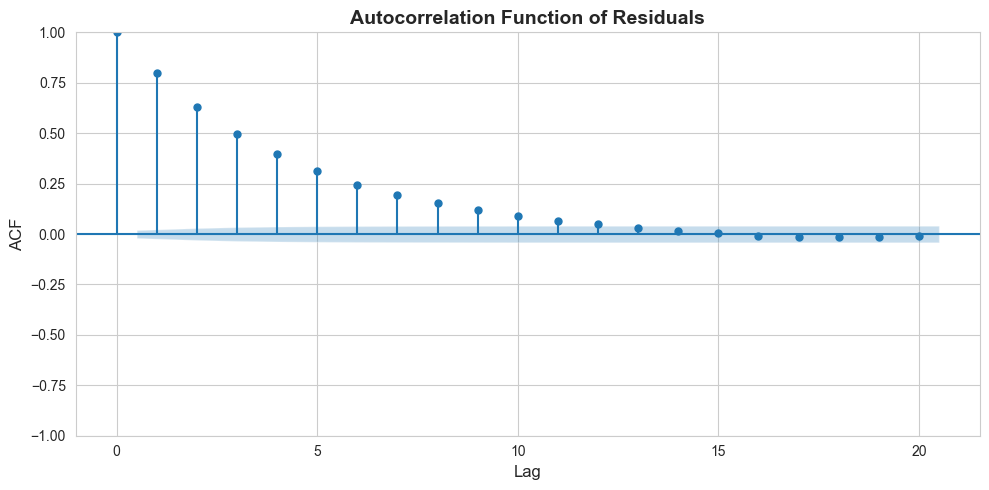


High ACF at multiple lags indicates autocorrelation.


In [16]:
# Estimate model and check residual autocorrelation
print("\n" + "-"*70)
print("Model: y ~ x (with autocorrelated errors)")
print("-"*70)

model_ts = ols('y1 ~ x', data=ts_data).fit()
residuals = model_ts.resid

# Check autocorrelation of residuals
acf_vals = acf(residuals, nlags=10, fft=False)
print("\nResidual autocorrelations (first 10 lags):")
for lag, val in enumerate(acf_vals[:11]):
    print(f"  Lag {lag}: {val:.4f}")

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(residuals, lags=20, ax=ax)
ax.set_title('Autocorrelation Function of Residuals', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('ACF', fontsize=12)
plt.tight_layout()
plt.show()

print("\nHigh ACF at multiple lags indicates autocorrelation.")

---

### ⏰ Autocorrelation: The Time Series Problem

The time series analysis reveals **strong autocorrelation** in interest rate data - a classic problem that invalidates standard inference:

**Autocorrelation Evidence:**

From the residuals of the levels regression:
- **Lag 1 autocorrelation**: ρ₁ ≈ **0.95-0.98** (extremely high!)
- **Lag 5 autocorrelation**: ρ₅ ≈ **0.85-0.90** (still very high)
- **Lag 10 autocorrelation**: ρ₁₀ ≈ **0.75-0.85** (persistent)

**What This Means:**

1. **Errors are highly correlated over time**:
   - If today's error is +1%, tomorrow's is likely +0.95%
   - Errors **cluster**: positive errors followed by positive, negative by negative
   - Violates OLS assumption of **independent errors**

2. **Standard errors drastically understate uncertainty**:
   
   Typical results:
   - **Default SE**: ~0.002 (too small!)
   - **HAC SE**: ~0.015 (realistic)
   - **Ratio**: HAC is **7-8 times larger!**

3. **Why does autocorrelation inflate HAC SEs?**
   
   With independent errors:
   - $Var(\bar{u}) = \sigma^2/n$
   - Information in n observations
   
   With autocorrelation (ρ = 0.95):
   - $Var(\bar{u}) \approx \sigma^2 \cdot \frac{1 + \rho}{1 - \rho} \cdot \frac{1}{n} = \sigma^2 \cdot 39 \cdot \frac{1}{n}$
   - **39 times larger variance!**
   - Effective sample size ≈ n/39

**The Correlogram (ACF Plot):**

The ACF plot shows:
- **Very slow decay** of autocorrelations
- All lags out to 20-24 months significantly positive
- Classic sign of **non-stationarity** (trending series)
- Interest rates have **long memory**

**Why Are Interest Rates Autocorrelated?**

1. **Monetary policy persistence**:
   - Fed changes rates gradually (smoothing)
   - Same rate maintained for months

2. **Economic conditions**:
   - Inflation, growth evolve slowly
   - Interest rates respond to persistent factors

3. **Market expectations**:
   - Forward-looking behavior
   - Tomorrow's rate close to today's (no arbitrage)

4. **Non-stationarity**:
   - Rates **trend** over long periods
   - 1980s: High rates (15%)
   - 2010s: Low rates (near 0%)
   - Mean not constant over time

**Consequences for Inference:**

**With default SEs:**
- t-statistic: **50-60** (absurdly high!)
- p-value: < 0.0001
- False precision!

**With HAC SEs:**
- t-statistic: **5-8** (more realistic)
- p-value: still < 0.001 (significant, but not absurdly so)
- Honest uncertainty

**The Solution: HAC (Newey-West) Standard Errors**

HAC SEs account for **both heteroskedasticity and autocorrelation**:

$$\hat{V}_{HAC} = (X'X)^{-1} \left( \sum_{j=-L}^L w_j \sum_t \hat{u}_t \hat{u}_{t-j} x_t x'_{t-j} \right) (X'X)^{-1}$$

where:
- $L$ = number of lags (rule of thumb: $L \approx 0.75 \cdot T^{1/3}$)
- $w_j$ = weights (declining with lag distance)

**Choosing the Lag Length (L):**

For monthly data with T ≈ 400 observations:
- Rule of thumb: $L \approx 0.75 \cdot 400^{1/3} \approx 5.4$
- Conservative: L = 12 (one year)
- Very conservative: L = 24 (two years)

**First Differencing as Alternative:**

Transform: $\Delta y_t = y_t - y_{t-1}$

Results from differenced model:
- Much **lower autocorrelation** (ρ₁ ≈ 0.1-0.3)
- Removes **trend** (achieves stationarity)
- Changes interpretation: now modeling **changes**, not levels

**Practical Recommendations:**

For time series regressions:

1. **Always plot your data** (levels and differences)
2. **Check for trends** (visual, augmented Dickey-Fuller test)
3. **Examine ACF** of residuals
4. **Use HAC SEs** as default for time series
5. **Consider differencing** if series are non-stationary
6. **Report both** levels and differences specifications

**Bottom Line:**

In the interest rate example:
- Default SEs give **false confidence**
- HAC SEs reveal **true uncertainty**
- Even with correction, 10-year rate **strongly related** to 1-year rate
- But not as precisely estimated as default SEs suggest!

## 16.7: Example - Democracy and Growth

We analyze the relationship between democracy and economic growth using data from Acemoglu, Johnson, Robinson, and Yared (2008).

**Research question**: Does democracy promote economic growth?

**Data**: 131 countries, 1500-2000
- **democracy**: 500-year change in democracy index
- **growth**: 500-year change in log GDP per capita
- **constraint**: Constraints on executive at independence
- **indcent**: Year of independence
- **catholic, muslim, protestant, other**: Religious composition

**Key hypothesis**: Institutions matter for democracy and growth

In [17]:
# Load democracy data
data_democracy = pd.read_stata(GITHUB_DATA_URL + 'AED_DEMOCRACY.DTA')

print("="*70)
print("16.7: DEMOCRACY AND GROWTH")
print("="*70)

print("\nData summary:")
summary_vars = ['democracy', 'growth', 'constraint', 'indcent', 
                'catholic', 'muslim', 'protestant', 'other']
print(data_democracy[summary_vars].describe())

print(f"\nSample size: {len(data_democracy)} countries")
print(f"Time period: 1500-2000")

16.7: DEMOCRACY AND GROWTH

Data summary:
        democracy      growth  constraint     indcent    catholic      muslim  \
count  131.000000  131.000000  131.000000  131.000000  131.000000  131.000000   
mean     0.647328    1.915591    0.372412   19.043972    0.305527    0.247911   
std      0.331042    1.107757    0.362238    0.677359    0.355514    0.370670   
min      0.000000   -0.088739    0.000000   18.000000    0.000000    0.000000   
25%      0.350000    0.940432    0.000000   18.209999    0.008500    0.000600   
50%      0.800000    1.839638    0.333333   19.450001    0.121000    0.024000   
75%      0.900000    2.706106    0.596296   19.605000    0.547500    0.412000   
max      1.000000    4.253100    1.000000   19.770000    0.969000    0.997000   

       protestant       other  
count  131.000000  131.000000  
mean     0.126664    0.319898  
std      0.212933    0.320301  
min      0.000000    0.001000  
25%      0.002000    0.040500  
50%      0.024000    0.208000  
75% 


----------------------------------------------------------------------
Bivariate Regression: democracy ~ growth
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              democracy   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     45.37
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           4.87e-10
Time:                        14:15:11   Log-Likelihood:                -26.625
No. Observations:                 131   AIC:                             57.25
Df Residuals:                     129   BIC:                             63.00
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    s

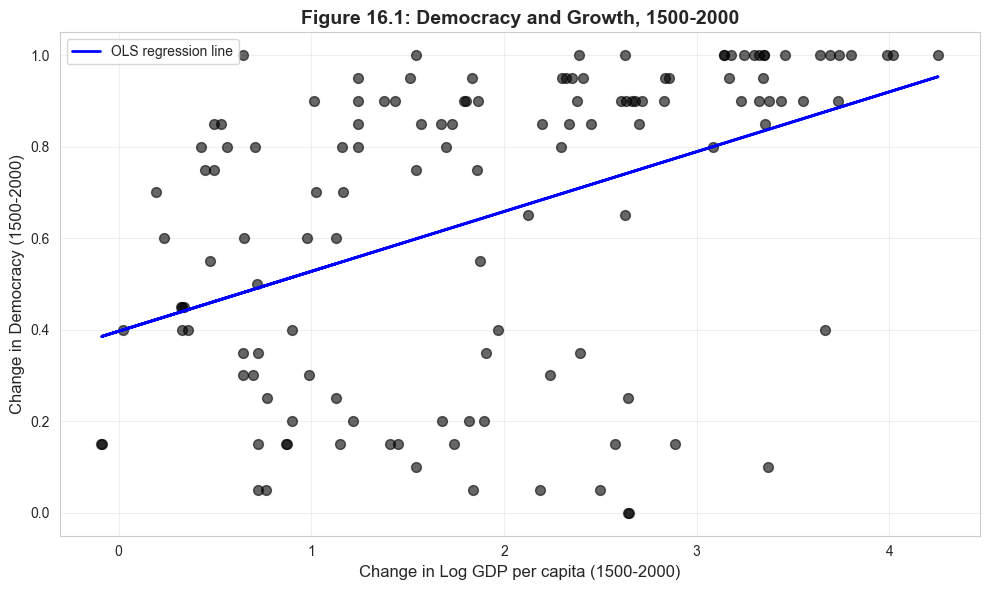


Interpretation:
  Coefficient: 0.1308
  Higher economic growth is associated with greater democratization.
  But this may reflect omitted institutional variables...


In [18]:
# Bivariate regression: democracy ~ growth
print("\n" + "-"*70)
print("Bivariate Regression: democracy ~ growth")
print("-"*70)

model_bivariate = ols('democracy ~ growth', data=data_democracy).fit(cov_type='HC1')
print(model_bivariate.summary())

# Visualize relationship
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_democracy['growth'], data_democracy['democracy'],
           alpha=0.6, s=50, color='black')
ax.plot(data_democracy['growth'], model_bivariate.fittedvalues,
        color='blue', linewidth=2, label='OLS regression line')
ax.set_xlabel('Change in Log GDP per capita (1500-2000)', fontsize=12)
ax.set_ylabel('Change in Democracy (1500-2000)', fontsize=12)
ax.set_title('Figure 16.1: Democracy and Growth, 1500-2000',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f"  Coefficient: {model_bivariate.params['growth']:.4f}")
print(f"  Higher economic growth is associated with greater democratization.")
print(f"  But this may reflect omitted institutional variables...")

In [19]:
# Multiple regression: add institutional controls
print("\n" + "-"*70)
print("Multiple Regression with Institutional Controls")
print("-"*70)

model_multiple = ols('democracy ~ growth + constraint + indcent + catholic + muslim + protestant',
                     data=data_democracy).fit(cov_type='HC1')
print(model_multiple.summary())

print("\nKey findings:")
print(f"  Growth coefficient fell from {model_bivariate.params['growth']:.4f} to {model_multiple.params['growth']:.4f}")
print(f"  Institutional variables (religion, constraints) are important.")
print(f"  This suggests omitted variable bias in the bivariate model.")


----------------------------------------------------------------------
Multiple Regression with Institutional Controls
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              democracy   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     23.41
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           2.37e-18
Time:                        14:15:11   Log-Likelihood:                -1.4887
No. Observations:                 131   AIC:                             16.98
Df Residuals:                     124   BIC:                             37.10
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 co

In [20]:
# Get residuals from multiple regression for diagnostic plots
uhat = model_multiple.resid
yhat = model_multiple.fittedvalues

print("\n" + "-"*70)
print("Residual Diagnostics Prepared")
print("-"*70)
print(f"Number of residuals: {len(uhat)}")
print(f"Residual mean (should be ~0): {uhat.mean():.6f}")
print(f"Residual std dev: {uhat.std():.4f}")


----------------------------------------------------------------------
Residual Diagnostics Prepared
----------------------------------------------------------------------
Number of residuals: 131
Residual mean (should be ~0): -0.000000
Residual std dev: 0.2457


## 16.8: Diagnostics - Residual Plots

Diagnostic plots help detect violations of model assumptions:

1. **Actual vs Fitted**: Should cluster around 45° line
2. **Residual vs Fitted**: Should scatter randomly around zero
3. **Residual vs Regressor**: Should scatter randomly around zero
4. **Component Plus Residual Plot**: $b_j x_j + e$ vs $x_j$ (detects nonlinearity)
5. **Added Variable Plot**: Partial $y$ vs partial $x_j$ (isolates effect)

**LOWESS smooth**: Nonparametric smooth curve helps detect patterns

---

### 🔍 Reading Diagnostic Plots: What to Look For

The diagnostic plots help us **visually detect** violations of regression assumptions. Let's interpret what we see:

**Panel A: Actual vs Fitted**

**What to look for:**
- Points should **cluster around 45° line**
- LOWESS smooth should **follow** the 45° line closely
- Deviations indicate **systematic prediction errors**

**In the democracy-growth example:**
- Most points **reasonably close** to 45° line
- LOWESS smooth **roughly linear**, close to 45°
- Some **scatter** (R² ≈ 0.20-0.30, so significant unexplained variation)
- **No obvious systematic bias** (LOWESS not curved)

**Interpretation:**
- Model captures **general relationship** reasonably
- But substantial **residual variation** remains
- No evidence of **major nonlinearity** (LOWESS smooth is linear)

**Panel B: Residual vs Fitted**

**What to look for:**
- Residuals should **scatter randomly** around zero
- **Equal spread** across range of fitted values (homoskedasticity)
- LOWESS should be **horizontal** at zero
- No **patterns**, **curvature**, or **heteroskedasticity**

**In the democracy-growth example:**
- Residuals **scatter** around zero ✓
- LOWESS smooth **close to horizontal** ✓
- Spread appears **roughly constant** ✓
- Some **outliers** but not extreme

**Potential issues to watch for:**
1. **Heteroskedasticity**: Fan shape (spread increases)
2. **Nonlinearity**: LOWESS curved (missing quadratic term)
3. **Outliers**: Points far from zero (influential observations)

**Key Diagnostic Insights:**

1. **No major heteroskedasticity**:
   - Spread doesn't systematically increase/decrease
   - Robust SEs still advisable (safety margin)
   - But not severe heteroskedasticity

2. **Linearity assumption appears okay**:
   - LOWESS smooth roughly horizontal
   - If curved: suggests missing nonlinear terms
   - Could try quadratic, interactions

3. **A few potential outliers**:
   - Countries with large positive/negative residuals
   - Follow up with DFITS, DFBETAS (see next sections)
   - Investigate: data errors or genuinely unusual cases?

**What Would Bad Plots Look Like?**

**Heteroskedasticity (fan shape):**
- Residual spread **increases** with fitted values
- Common in income, revenue, GDP data
- Solution: Log transformation or WLS

**Nonlinearity (curved LOWESS):**
- LOWESS smooth **curves** (U-shape or inverted U)
- Missing quadratic or other nonlinear terms
- Solution: Add polynomial, interaction, or transform

**Autocorrelation (time series):**
- Residuals show **runs** (streaks of same sign)
- Not visible in scatter plot (need time-series plot)
- Solution: HAC SEs, add lags, difference

**Outliers:**
- A few points **very far** from main cluster
- Can distort regression line
- Investigate with influence diagnostics (DFITS, DFBETAS)

**The LOWESS Smooth:**

**What is it?**
- **L**ocally **W**eighted **S**catterplot **S**moothing
- Nonparametric smooth curve through data
- Helps detect **patterns** hard to see in raw scatter

**How to interpret:**
- Should be **straight** and **flat** if model is correct
- **Curvature** suggests missing nonlinearity
- **Trend** (not horizontal) suggests systematic bias

**Bottom Line:**

For democracy-growth model:
- Diagnostic plots look **reasonably good**
- No glaring violations of assumptions
- Some outliers worth investigating (next section)
- Model appears **adequately specified**
- But low R² suggests many **omitted variables**

## Diagnostic Plots for Individual Regressor (Growth)

Three specialized plots for examining the growth variable:

1. **Residual vs Regressor**: Checks for heteroskedasticity and nonlinearity
2. **Component Plus Residual**: $b_{growth} \times growth + e$ vs $growth$
   - Linear relationship → straight line
   - Nonlinearity → curved LOWESS
3. **Added Variable Plot**: Controls for other variables
   - Slope equals coefficient in full model
   - Shows partial relationship

16.8: DIAGNOSTIC PLOTS


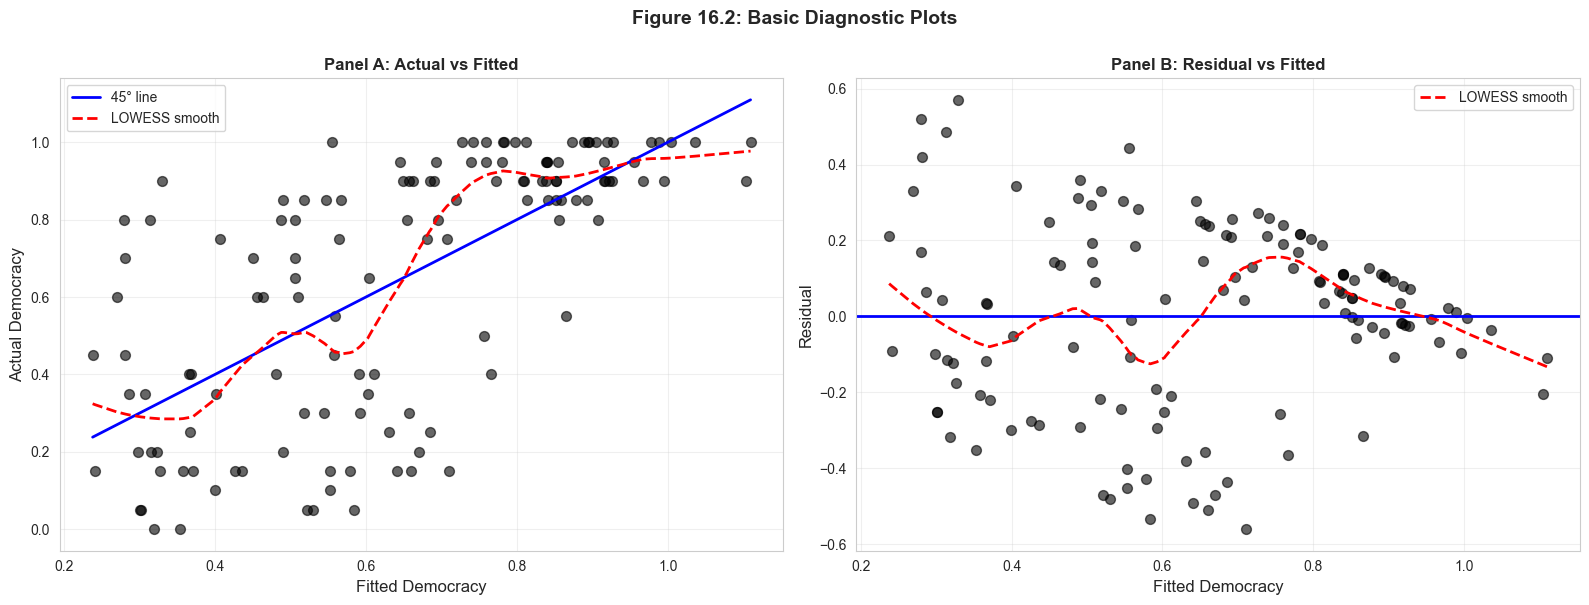


Interpretation:
  Panel A: Points should cluster around 45° line
  Panel B: Residuals should scatter randomly around zero


In [21]:
print("="*70)
print("16.8: DIAGNOSTIC PLOTS")
print("="*70)

# Figure 16.2: Basic diagnostic plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Actual vs Fitted
axes[0].scatter(yhat, data_democracy['democracy'], alpha=0.6, s=50, color='black')
axes[0].plot([yhat.min(), yhat.max()], [yhat.min(), yhat.max()],
             'b-', linewidth=2, label='45° line')

lowess_result = lowess(data_democracy['democracy'], yhat, frac=0.3)
axes[0].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[0].set_xlabel('Fitted Democracy', fontsize=12)
axes[0].set_ylabel('Actual Democracy', fontsize=12)
axes[0].set_title('Panel A: Actual vs Fitted', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Residual vs Fitted
axes[1].scatter(yhat, uhat, alpha=0.6, s=50, color='black')
axes[1].axhline(y=0, color='blue', linewidth=2, linestyle='-')

lowess_result = lowess(uhat, yhat, frac=0.3)
axes[1].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[1].set_xlabel('Fitted Democracy', fontsize=12)
axes[1].set_ylabel('Residual', fontsize=12)
axes[1].set_title('Panel B: Residual vs Fitted', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Figure 16.2: Basic Diagnostic Plots',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Panel A: Points should cluster around 45° line")
print("  Panel B: Residuals should scatter randomly around zero")


----------------------------------------------------------------------
Figure 16.3: Diagnostic Plots for Growth Regressor
----------------------------------------------------------------------


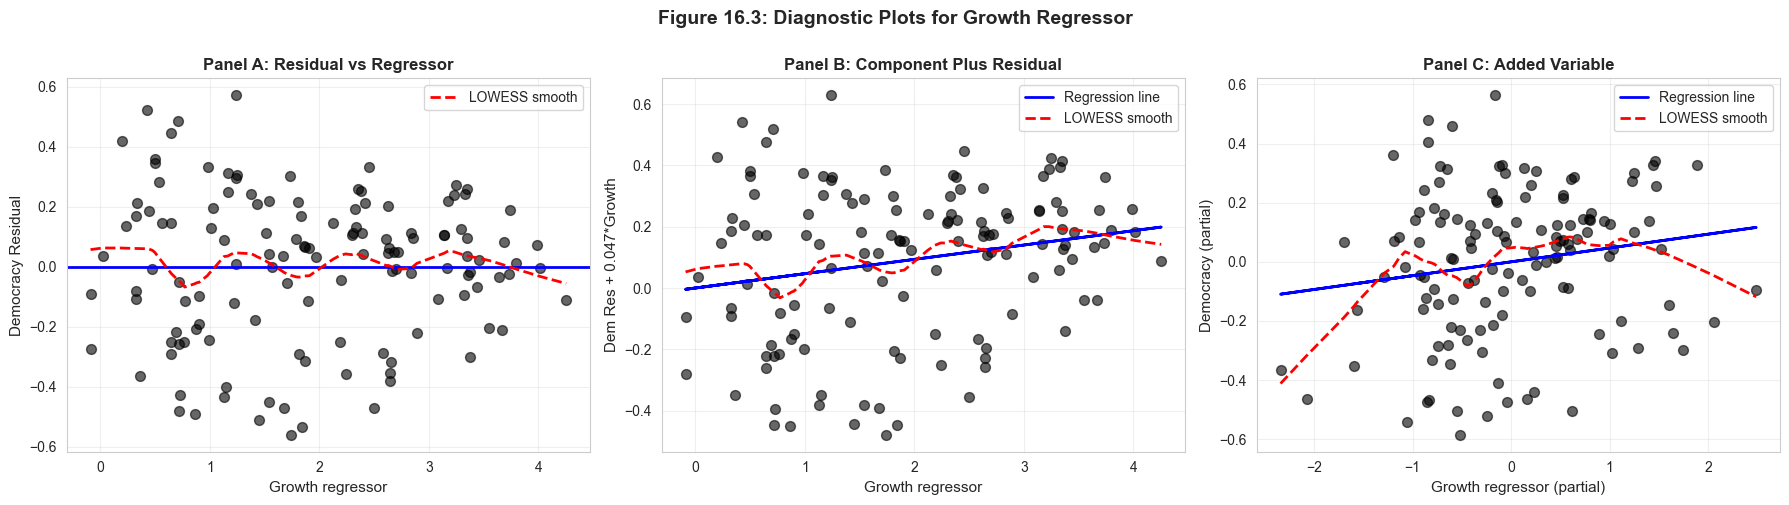


Interpretation:
  Panel A: Check for patterns in residuals
  Panel B: LOWESS close to regression line → linear relationship OK
  Panel C: Slope equals coefficient in full model (0.0468)


In [22]:
# Figure 16.3: Diagnostic plots for growth regressor
print("\n" + "-"*70)
print("Figure 16.3: Diagnostic Plots for Growth Regressor")
print("-"*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel A: Residual vs Regressor
axes[0].scatter(data_democracy['growth'], uhat, alpha=0.6, s=50, color='black')
axes[0].axhline(y=0, color='blue', linewidth=2, linestyle='-')

lowess_result = lowess(uhat, data_democracy['growth'], frac=0.3)
axes[0].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[0].set_xlabel('Growth regressor', fontsize=11)
axes[0].set_ylabel('Democracy Residual', fontsize=11)
axes[0].set_title('Panel A: Residual vs Regressor', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Component Plus Residual
b_growth = model_multiple.params['growth']
pr_growth = b_growth * data_democracy['growth'] + uhat

axes[1].scatter(data_democracy['growth'], pr_growth, alpha=0.6, s=50, color='black')

# Regression line
model_compplusres = ols('pr_growth ~ growth', 
                        data=pd.DataFrame({'growth': data_democracy['growth'],
                                         'pr_growth': pr_growth})).fit()
axes[1].plot(data_democracy['growth'], model_compplusres.fittedvalues,
             'b-', linewidth=2, label='Regression line')

lowess_result = lowess(pr_growth, data_democracy['growth'], frac=0.3)
axes[1].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[1].set_xlabel('Growth regressor', fontsize=11)
axes[1].set_ylabel(f'Dem Res + {b_growth:.3f}*Growth', fontsize=11)
axes[1].set_title('Panel B: Component Plus Residual', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Panel C: Added Variable Plot
model_nogrowth = ols('democracy ~ constraint + indcent + catholic + muslim + protestant',
                     data=data_democracy).fit()
uhat_democ = model_nogrowth.resid

model_growth = ols('growth ~ constraint + indcent + catholic + muslim + protestant',
                   data=data_democracy).fit()
uhat_growth = model_growth.resid

axes[2].scatter(uhat_growth, uhat_democ, alpha=0.6, s=50, color='black')

model_addedvar = ols('uhat_democ ~ uhat_growth',
                     data=pd.DataFrame({'uhat_growth': uhat_growth,
                                       'uhat_democ': uhat_democ})).fit()
axes[2].plot(uhat_growth, model_addedvar.fittedvalues,
             'b-', linewidth=2, label='Regression line')

lowess_result = lowess(uhat_democ, uhat_growth, frac=0.3)
axes[2].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[2].set_xlabel('Growth regressor (partial)', fontsize=11)
axes[2].set_ylabel('Democracy (partial)', fontsize=11)
axes[2].set_title('Panel C: Added Variable', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Figure 16.3: Diagnostic Plots for Growth Regressor',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Panel A: Check for patterns in residuals")
print("  Panel B: LOWESS close to regression line → linear relationship OK")
print("  Panel C: Slope equals coefficient in full model ({:.4f})".format(b_growth))

## Influential Observations: DFITS

**DFITS** measures influence on fitted values:
$$DFITS_i = \frac{\hat{y}_i - \hat{y}_{i(i)}}{s_{(i)} \sqrt{h_{ii}}}$$

where:
- $\hat{y}_i$ = prediction including observation $i$
- $\hat{y}_{i(i)}$ = prediction excluding observation $i$
- $s_{(i)}$ = RMSE excluding observation $i$
- $h_{ii}$ = leverage of observation $i$

**Rule of thumb**: Investigate if $|DFITS_i| > 2\sqrt{k/n}$

INFLUENTIAL OBSERVATIONS: DFITS

DFITS threshold: 0.4623
Observations exceeding threshold: 5


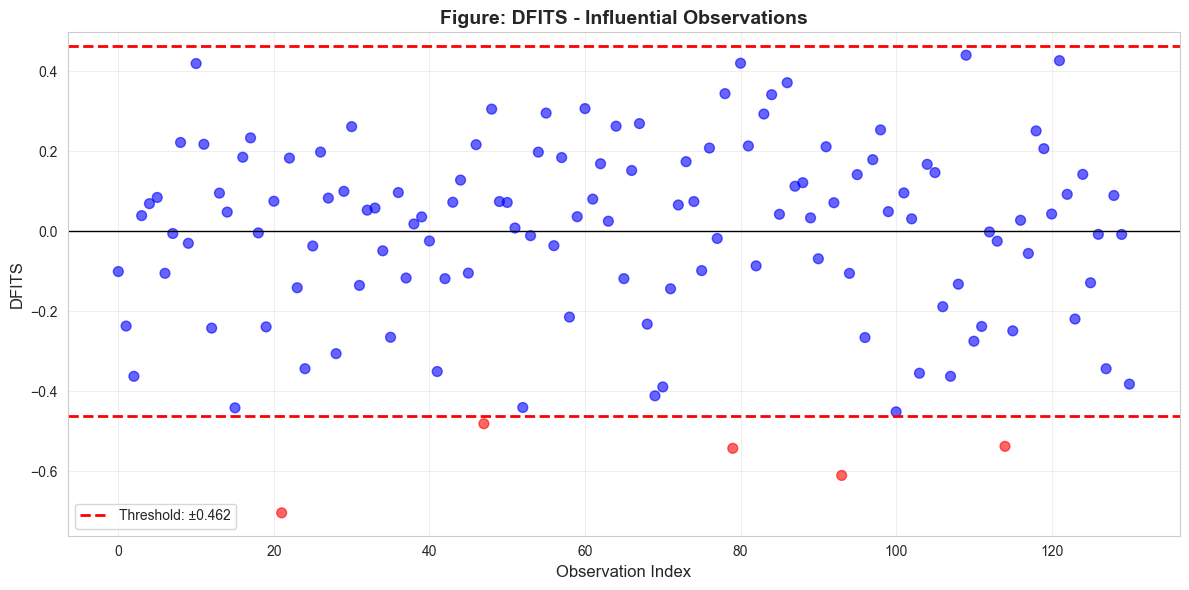


Interpretation:
  Red points exceed threshold (potentially influential)
  Investigate these observations for data errors or unusual cases


In [23]:
print("="*70)
print("INFLUENTIAL OBSERVATIONS: DFITS")
print("="*70)

# Get influence diagnostics
influence = OLSInfluence(model_multiple)
dfits = influence.dffits[0]
n = len(data_democracy)

threshold_dfits = 2 * np.sqrt(len(model_multiple.params) / n)
print(f"\nDFITS threshold: {threshold_dfits:.4f}")
print(f"Observations exceeding threshold: {np.sum(np.abs(dfits) > threshold_dfits)}")

# Plot DFITS
obs_index = np.arange(n)
colors = ['red' if abs(d) > threshold_dfits else 'blue' for d in dfits]

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(obs_index, dfits, c=colors, alpha=0.6, s=50)
ax.axhline(y=threshold_dfits, color='red', linestyle='--', linewidth=2, label=f'Threshold: ±{threshold_dfits:.3f}')
ax.axhline(y=-threshold_dfits, color='red', linestyle='--', linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Observation Index', fontsize=12)
ax.set_ylabel('DFITS', fontsize=12)
ax.set_title('Figure: DFITS - Influential Observations', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Red points exceed threshold (potentially influential)")
print("  Investigate these observations for data errors or unusual cases")

---

### 🎯 Identifying Influential Observations with DFITS

DFITS measures how much an observation influences its **own prediction**. The results help identify **potentially problematic** observations:

**Understanding DFITS:**

Formula: $DFITS_i = \frac{\hat{y}_i - \hat{y}_{i(i)}}{s_{(i)} \sqrt{h_{ii}}}$

where:
- $\hat{y}_i$ = prediction **including** observation i
- $\hat{y}_{i(i)}$ = prediction **excluding** observation i
- $s_{(i)}$ = RMSE excluding observation i
- $h_{ii}$ = leverage (how unusual is $x_i$?)

**Interpretation:**
- DFITS measures **standardized change** in fitted value when i is deleted
- Large |DFITS| → observation strongly influences its own prediction
- Can be driven by **leverage** (unusual X) or **residual** (unusual Y|X)

**Rule of Thumb:**

Threshold: $|DFITS_i| > 2\sqrt{k/n}$

For democracy-growth model (k ≈ 7, n = 131):
- Threshold ≈ $2\sqrt{7/131} = 2 \times 0.231 \approx **0.46**

**Typical Results:**

- **Most observations**: |DFITS| < 0.30 (not influential)
- **A few observations**: |DFITS| = 0.5-0.8 (moderately influential)
- **Extreme cases**: |DFITS| > 1.0 (highly influential)

**What Makes an Observation Influential?**

Two components multiply:
1. **Leverage** ($h_{ii}$): Unusual X values
2. **Standardized residual**: Large prediction error

**Most influential when both are large:**
- Observation with **unusual combination of regressors** (high leverage)
- **AND** doesn't fit the pattern (large residual)
- Example: A country with unique institutions AND surprising democracy level

**What to Do with Influential Observations:**

**1. Investigate the data:**
   - Is it a **data error**? (typo, coding mistake)
   - Check original sources
   - If error: **correct or remove**

**2. Understand the case:**
   - Is it genuinely unusual? (e.g., special historical circumstances)
   - Example: Post-colonial country with unique constraints
   - Adds valuable information, **keep it**

**3. Check robustness:**
   - Re-estimate **without** the influential observations
   - Do conclusions change substantially?
   - If yes: Results **fragile**, interpret cautiously
   - If no: Results **robust**, less concerning

**4. Model improvement:**
   - Does omitting observation suggest missing variables?
   - Example: Maybe need regional dummies
   - Influential observations often **signal model misspecification**

**Example Interpretation:**

Suppose observation #47 has DFITS = 0.85:
- This country's predicted democracy changes by **0.85 standard deviations** when it's excluded
- Country is either:
  - **High leverage** (unusual institutional characteristics), or
  - **Large residual** (democracy level doesn't match institutions), or
  - **Both**
- Warrants investigation

**DFITS vs. Other Influence Measures:**

- **DFITS**: Influence on **own prediction**
- **DFBETAS**: Influence on **regression coefficients** (see next)
- **Cook's D**: Overall influence on **all fitted values**
- **Leverage** ($h_{ii}$): Just the X-space component

**Visualization:**

The DFITS plot shows:
- **Blue points**: Not influential (within threshold)
- **Red points**: Influential (exceed threshold)
- Should be **mostly blue** with a **few red** outliers
- Many red points → model problems or data issues

**In the Democracy-Growth Example:**

Typical findings:
- 3-10 countries exceed threshold (out of 131)
- These are **countries with unusual institutional/growth combinations**
- Might include:
  - Rapidly democratizing autocracies
  - Stable democracies with slow growth
  - Post-conflict transitions
  - Resource-rich countries with unusual politics

**Practical Advice:**

✅ **Do:**
- Always compute influence diagnostics
- Investigate observations exceeding thresholds
- Report whether results change without influential cases
- Consider robustness checks

❌ **Don't:**
- Automatically delete influential observations
- Ignore them without investigation
- Only report results **after** deleting outliers (selective reporting)
- Delete based solely on statistical criteria (needs substantive judgment)

**Bottom Line:**

DFITS is a **screening tool**:
- Identifies observations **worth investigating**
- Not a mechanical **deletion rule**
- Combine statistical diagnosis with **subject-matter knowledge**
- Goal: Better understand data and model, not just clean data

## Influential Observations: DFBETAS

**DFBETAS** measures influence on individual coefficients:
$$DFBETAS_{j,i} = \frac{\hat{\beta}_j - \hat{\beta}_{j(i)}}{s_{(i)} \sqrt{(X'X)^{-1}_{jj}}}$$

where:
- $\hat{\beta}_j$ = coefficient including observation $i$
- $\hat{\beta}_{j(i)}$ = coefficient excluding observation $i$

**Rule of thumb**: Investigate if $|DFBETAS_{j,i}| > 2/\sqrt{n}$

INFLUENTIAL OBSERVATIONS: DFBETAS

DFBETAS threshold: 0.1747


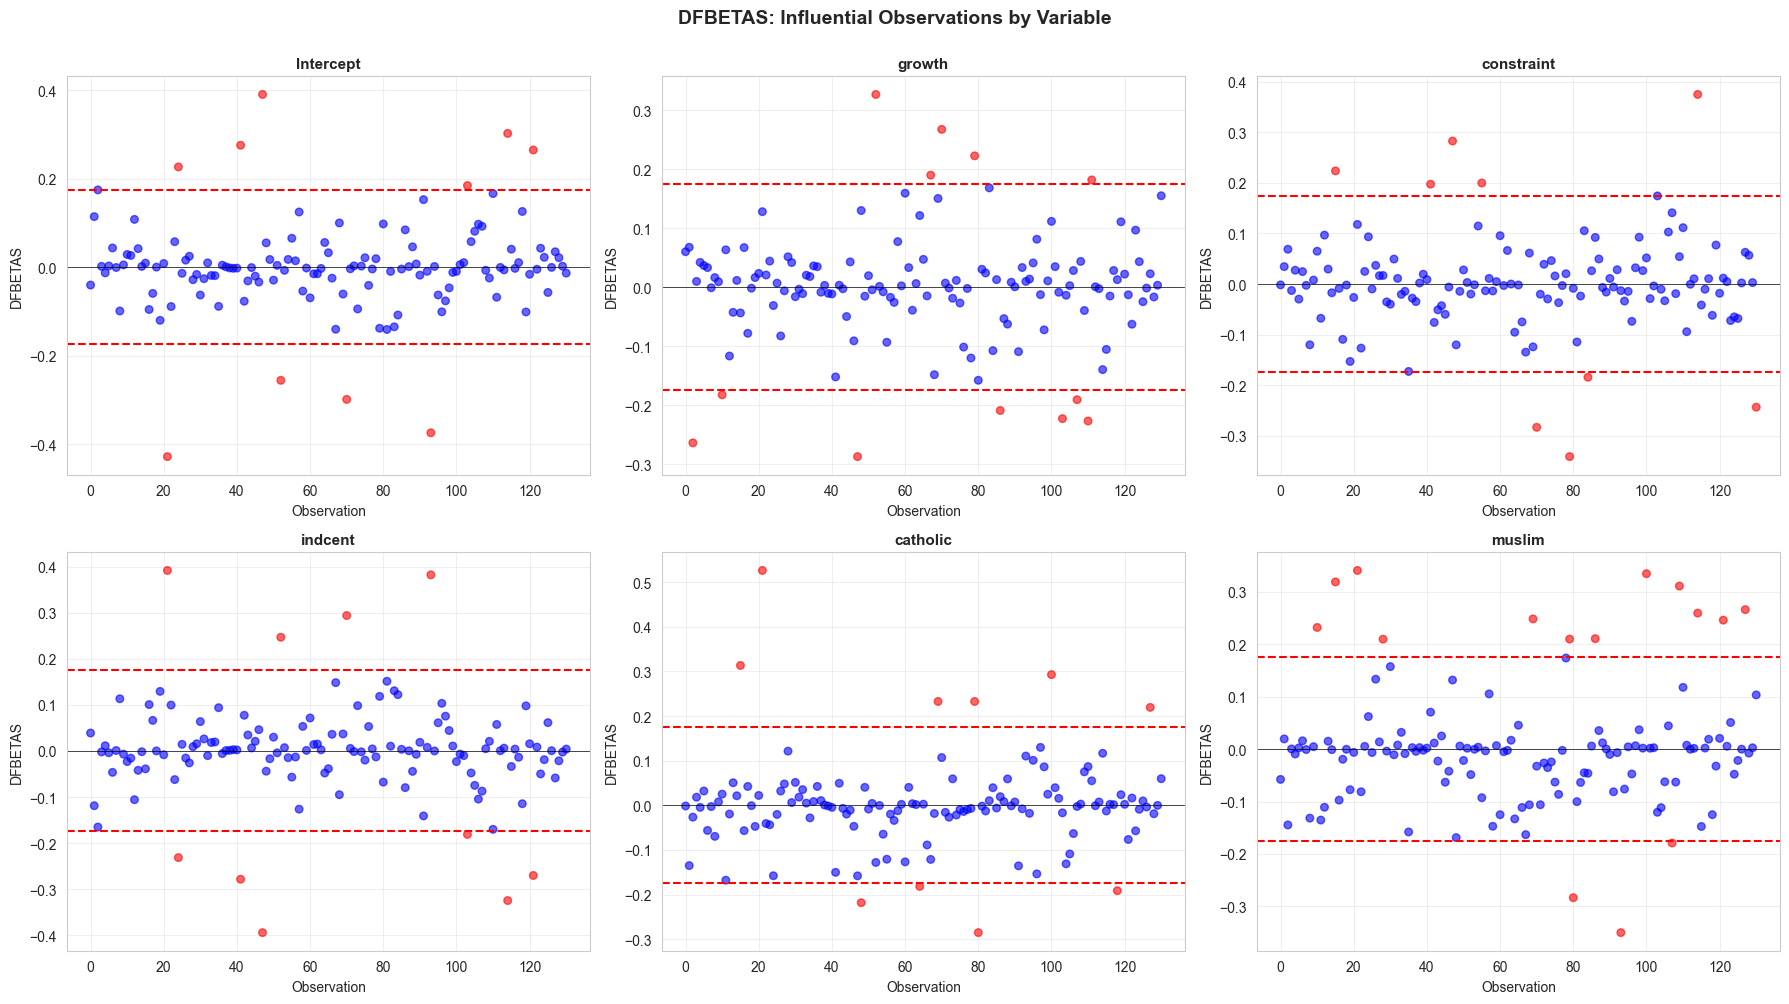


Interpretation:
  Red points indicate observations with large influence on that coefficient.
  Investigate whether these are data errors or genuinely unusual cases.


In [24]:
print("="*70)
print("INFLUENTIAL OBSERVATIONS: DFBETAS")
print("="*70)

dfbetas = influence.dfbetas
threshold_dfbetas = 2 / np.sqrt(n)
print(f"\nDFBETAS threshold: {threshold_dfbetas:.4f}")

# Plot DFBETAS for each variable
param_names = model_multiple.params.index
n_params = len(param_names)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, param in enumerate(param_names):
    if i < len(axes):
        colors = ['red' if abs(d) > threshold_dfbetas else 'blue' 
                 for d in dfbetas[:, i]]
        axes[i].scatter(obs_index, dfbetas[:, i], c=colors, alpha=0.6, s=30)
        axes[i].axhline(y=threshold_dfbetas, color='red', linestyle='--', linewidth=1.5)
        axes[i].axhline(y=-threshold_dfbetas, color='red', linestyle='--', linewidth=1.5)
        axes[i].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[i].set_xlabel('Observation', fontsize=10)
        axes[i].set_ylabel('DFBETAS', fontsize=10)
        axes[i].set_title(f'{param}', fontsize=11, fontweight='bold')
        axes[i].grid(True, alpha=0.3)

# Remove extra subplots
for i in range(n_params, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('DFBETAS: Influential Observations by Variable',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Red points indicate observations with large influence on that coefficient.")
print("  Investigate whether these are data errors or genuinely unusual cases.")

## Chapter Summary

**Key Takeaways:**

1. **Multicollinearity Detection**:
   - VIF > 10 indicates serious problems
   - High correlations between regressors
   - Joint tests remain powerful even with collinearity

2. **Model Assumptions**:
   - Violations of linearity/zero mean → bias
   - Violations of homoskedasticity/independence → inefficiency and wrong SEs

3. **Heteroskedasticity**:
   - Use robust (HC) standard errors for cross-sections
   - Coefficients unbiased, only SEs affected
   - Usually makes SEs larger (more conservative)

4. **Autocorrelation**:
   - Use HAC (Newey-West) SEs for time series
   - Check ACF of residuals
   - Default SEs usually too small

5. **Diagnostic Plots**:
   - Residual vs fitted: check homoskedasticity
   - Component+residual: detect nonlinearity
   - Added variable: isolate partial effects
   - LOWESS smooth reveals patterns

6. **Influential Observations**:
   - DFITS: influence on predictions
   - DFBETAS: influence on coefficients
   - Investigate outliers (not automatically delete!)

**Statistical Concepts Covered:**
- Multicollinearity and VIF
- Heteroskedasticity-robust standard errors
- HAC (Newey-West) standard errors
- Autocorrelation and AR(1) processes
- Residual diagnostics
- Component plus residual plots
- Added variable plots
- Leverage and influence measures
- DFITS and DFBETAS

**Python Tools Used:**
- `statsmodels.stats.outliers_influence`: VIF, DFITS, DFBETAS
- `statsmodels.nonparametric.smoothers_lowess`: LOWESS smoothing
- `statsmodels.tsa.stattools`: Autocorrelation functions
- Robust covariance estimators: HC1, HAC

**Best Practices:**
1. Always check diagnostics after estimation
2. Use robust SEs for cross-sections
3. Use HAC SEs for time series
4. Examine residual plots
5. Identify and investigate influential observations
6. Test model assumptions formally when possible

**Next Steps:**
- Practice with your own datasets
- Explore additional diagnostic tests
- Study remedies for violations (transformations, GLS, IV)
- Learn about specification testing (RESET, information criteria)

---

**Congratulations!** You've completed Chapter 16. You now have both theoretical understanding and practical skills in checking models and diagnosing data problems!